> f = 1.83.
> Dataset 0.
> Using evenly spaced ordered times.
Data vector: [(0.2, 0), (0.3324324324324325, 1), (0.4648648648648649, 1), (0.5972972972972974, 1), (0.7297297297297298, 0), (0.8621621621621622, 0), (0.9945945945945946, 0), (1.127027027027027, 1), (1.2594594594594595, 1), (1.3918918918918919, 0), (1.5243243243243243, 1), (1.6567567567567567, 1), (1.7891891891891893, 0), (1.9216216216216218, 0), (2.0540540540540544, 0), (2.1864864864864866, 1), (2.318918918918919, 0), (2.451351351351352, 0), (2.583783783783784, 1), (2.7162162162162167, 1), (2.848648648648649, 1), (2.9810810810810815, 0), (3.1135135135135137, 0), (3.2459459459459463, 1), (3.378378378378379, 1), (3.510810810810811, 0), (3.643243243243244, 1), (3.775675675675676, 1), (3.9081081081081086, 0), (4.04054054054054, 0), (4.172972972972973, 0), (4.305405405405406, 1), (4.437837837837838, 1), (4.570270270270271, 0), (4.7027027027027035, 0), (4.835135135135135, 0), (4.967567567567568, 1), (5.1000000000000005, 0), (5.232

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:235: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: underflow encountered in exp
  return f_raw(*args, **kwargs)


----------------
Median results: 
- f = 1.8238
- Variance:  0.000000
- MSE:       0.000038
- Deviation:  0.0062
* Percentage of HMC steps:  0.0%.
* Metropolis-Hastings:     10% mean particle acceptance rate.
(n=1; runs=1; 2d)


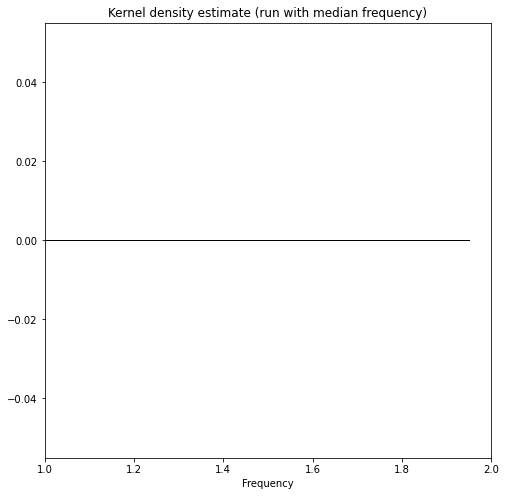

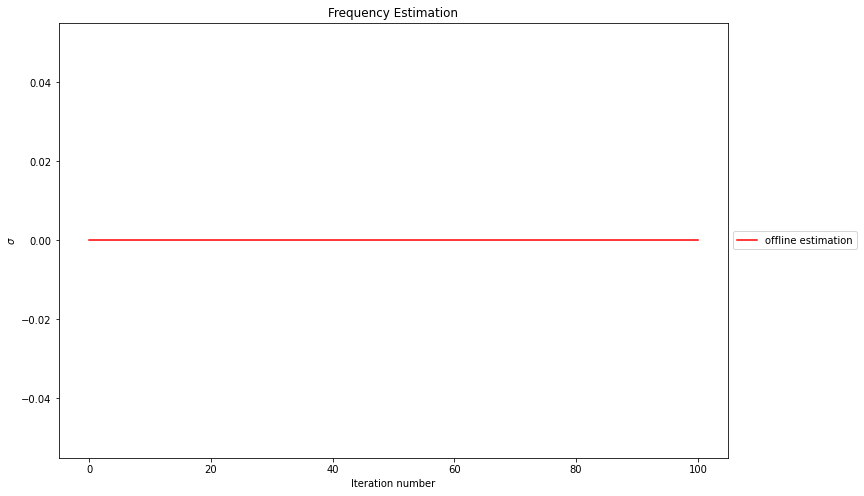

In [41]:
# -*- coding: utf-8 -*-
"""
Hamiltonian learning implementation for estimating a frequency using offline 
Bayesian inference.
The qubit is assumed to be initialized at state |1> for each iteration, and to
evolve under H = f*sigma_x/2, apart from the exponential decay resulting from 
the presence of decoherence. Estimation is performed for both the precession
frequency and the coherence time (or its inverse).
A sequential Monte Carlo approximation is used to represent the probability 
distributions, using Hamiltonian Monte Carlo and/or Metropolis-Hastings mutation 
steps.
The evolution of the standard deviations with the steps is plotted, and the 
final  values of these quantities (in addition to the actual error) are 
printed.
The algorithm is repeated for a number of runs with randomly picked real
values, and medians are taken over all of them to get the results and graphs.
"""

import sys, copy, random, pickle, matplotlib.pyplot as plt
from autograd import grad, numpy as np
import warnings
warnings.simplefilter("default") # error, ignore, default, always, once
np.seterr(all='warn')
dim=1
total_HMC, accepted_HMC = 0, 0
total_MH, accepted_MH = 0, 0

N_particles = 1 # Number of samples used to represent the probability
#distribution, using a sequential Monte Carlo approximation.

f_real = 0 

left_boundaries = np.array([1])
right_boundaries = np.array([2])

def measure(t, particle=np.array([f_real])):
    '''
    Simulates the measurement of the quantum system of the z component of spin 
    at a given time t.
    
    Parameters
    ----------
    t: float
        The evolution time between the initialization and the projection.
    particle: [float], optional
        The set of real dynamical parameters governing the system's evolution 
    (Default is [f_real,alpha_real]).
        
    Returns
    -------
    1 if the result is |1>, 0 if it is |0>.
    '''
    r = np.random.binomial(1, 
                           p=(np.cos(2*np.pi*f_real*t/2)**2*np.exp(-alpha_real*t)+
                              (1-np.exp(-alpha_real*t))/2))
    return r

def simulate_1(particle, t):
    '''
    Provides an estimate for the likelihood  P(D=1|test_f,t) of an x-spin 
    measurement at time t yielding result |+>, given a set of parameters for 
    the fixed form Hamiltonian. 
    
    Parameters
    ----------
    particle: [float]
        The set of dynamical parameters to be used in the simulation.
    t: float
        The evolution time between the initialization and the projection.
        
    Returns
    -------
    p: float
        The estimated probability of finding the particle at state |1>.
    '''
    test_f = particle[0]
    p=np.cos(2*np.pi*test_f*t/2)**2
    return p 

def likelihood(data,particle):
    '''
    Provides an estimate for the likelihood  P(D|test_f,t) of z-spin 
    measurements yielding the input vector of data, given test parameters for  
    the fixed form Hamiltonian. 
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    particle: [float]
        The set of dynamical parameters to be used for the likelihood.s
        
    Returns
    -------
    p: float
        The estimated probability of obtaining the input outcome. 
    '''
    l = np.product([simulate_1(particle,t) if (outcome==1)
                        else 1-simulate_1(particle,t) for (t,outcome) in data])
    return l

def target_U(data,particle):
    '''
    Evaluates the target "energy" associated to the joint likelihood of some 
    vector  of data, given a set of parameters for the fixed form Hamiltonian. 
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    particle: [float]
        The set of dynamical parameters to be used for the likelihood.
        
    Returns
    -------
    U: float
        The value of the "energy".
    '''
    U = -np.log(likelihood(data, particle)) 
    return (U)

def U_gradient(data,particle,autograd=False):
    '''
    Evaluates the gradient of the target "energy" associated to the likelihood 
    at a time t seen as a probability density, given a set of parameters for         
    the fixed form Hamiltonian. 
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    particle: [float]
        The set of dynamical parameters to be used for the likelihood.
    autograd: bool, optional
        Whether to use automatic differenciation (Default is False).
        
    Returns
    -------
    DU: [float]
        The gradient of the "energy".
    '''
    if autograd:
        DU_f = grad(target_U,1)
        DU = np.array(DU_f(data,particle))
    else:
        test_f = particle[0]
        DU = np.array([0.])
        for (t,outcome) in data:
            arg = 2*np.pi*test_f*t/2
            L1 = np.cos(arg)**2
            DL1 = -2*np.pi*t*np.sin(arg)*np.cos(arg)
            if outcome==1:
                DU -= np.array([DL1/L1])
            if outcome==0:
                L0 = 1-L1
                DL0 = -DL1
                DU -= np.array([DL0/L0])
    return(DU)
    
def test_differentiation():
    '''
    Tests the analytical differentiation in `U_gradient` by comparing its
    numerical result against the one computed by automatic differentiation.
    Both are evaluated for the same representative set of inputs and printed on 
    the console.
    '''
    data = np.array([(random.random(),1),(random.random(),0)])
    particle = np.array([random.random() for d in range(dim)])
    print("Autodiff: ", U_gradient(data,particle,autograd=True))
    print("Analytical: ",U_gradient(data,particle,autograd=False))
    
first_metropolis_hastings_step = True
def metropolis_hastings_step(data, particle, S=np.identity(2),
                             factor=0.01,
                             left_constraints=left_boundaries, 
                             right_constraints=right_boundaries):
    '''
    Performs a Metropolis-Hastings mutation on a given particle, using a 
    gaussian function for the proposals.
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    particle: [float]
        The particle to undergo a mutation step.
    S: [[float]]
        The covariance matrix that will determine the standard deviations
        of the normal distributions used for the proposal in each dimension
        (the dth diagonal element corresponding to dimension d).
    factor: float
        The factor M is to be multiplied by to get the actual standard 
        deviations.
    left_constraints: [float]
        The leftmost bounds to be enforced for the particle's motion.
    right_constraints: [float]
        The rightmost bounds to be enforced for the particle's motion.
        
    Returns
    -------
    particle: [float]
        The mutated particle.
    p: float
        The acceptance probability to be used for the evolved particle as a 
        Monte Carlo proposal.
    '''
    global first_metropolis_hastings_step, dim
    if first_metropolis_hastings_step:
      if not np.array_equal(S,np.identity(dim)):
          Cov = "Cov"
      else:
          Cov = "I"
      print("MH:  S=%s, factor=%.4f" % (Cov,factor))
      first_metropolis_hastings_step = False

    Sigma = factor*S
    # Start with any invalid point.
    new_particle = np.array([left_constraints[i]-1 for i in range(dim)]) 
    
    # Get a proposal that satisfies the constraints.
    while any([new_particle[i]<left_constraints[i] for i in range(dim)] + 
                  [new_particle[i]>right_constraints[i] for i in range(dim)]):
        new_particle = np.array([np.random.normal(particle[i], Sigma[i][i])
                                 for i in range(dim)])

    p = likelihood(data,new_particle)/likelihood(data,particle)
    return new_particle,p
    
def simulate_dynamics(data, initial_momentum, initial_particle, M,L,eta,
                      left_constraints=left_boundaries, 
                      right_constraints=right_boundaries):  
    '''
    Simulates Hamiltonian dynamics for a given particle, using leapfrog 
    integration.
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    initial_momentum: [float]
        The starting momentum vector. 
    initial_particle: [float]
        The particle for which the Hamiltonian dynamics is to be simulated.
    M: [[float]]
        The mass matrix/Euclidean metric to be used when simulating the
        Hamiltonian dynamics (a HMC tuning parameter).
    L: int
        The amount of integration steps to be used when simulating the 
        Hamiltonian dynamics (a HMC tuning parameter).
    eta: float
        The integration stepsize to be used when simulating the Hamiltonian 
        dynamics (a HMC tuning parameter).
    left_constraints: [float]
        The leftmost bounds to be enforced for the particle's motion.
    right_constraints: [float]
        The rightmost bounds to be enforced for the particle's motion.
        
    Returns
    -------
    particle: [float]
        The particle having undergone motion.
    p: float
        The acceptance probability to be used for the evolved particle as a 
        Monte Carlo proposal.
    '''  
    M_inv = np.linalg.inv(M)
    new_particle = initial_particle
    DU = U_gradient(data,new_particle)
    #print("initial: ", initial_particle)
    #print("DU0: ",DU)
    # Perform leapfrog integration according to Hamilton's equations.
    new_momentum = np.add(initial_momentum,-0.5*eta*DU)
    for l in range(L):
        new_particle = np.add(new_particle,np.dot(M_inv,eta*new_momentum))
        
        # Enforce the constraints that both the frequency and the decay 
        #parameter lie within the prior distribution. 
        # Should a limit be crossed, the position and momentum are chosen such 
        #that the particle "rebounds".
        for i in range(dim):
            if (new_particle[i] < left_constraints[i]):
                new_particle[i] = left_constraints[i]+\
                    (left_constraints[i]-new_particle[i])
                new_momentum[i] = -new_momentum[i]
            if (new_particle[i] > right_constraints[i]):
                new_particle[i] = right_constraints[i]-\
                    (new_particle[i]-right_constraints[i])
                new_momentum[i] = -new_momentum[i]
        DU = U_gradient(data,new_particle)
        if (l != L-1):
            new_momentum = np.add(new_momentum,-eta*DU)     
    new_momentum = np.add(new_momentum,-0.5*eta*DU)
    
    #print("final: ",new_particle)
    # Compute the acceptance probability.
    p = np.exp(target_U(data,initial_particle)
               -target_U(data,new_particle)
               +np.sum(np.linalg.multi_dot(
                   [initial_momentum,M_inv,initial_momentum]))/2
               -np.sum(np.linalg.multi_dot(
                   [new_momentum,M_inv,new_momentum]))/2)
    #print("acceptance prob: ",p)
    return new_particle, p
        
first_hamiltonian_MC_step = True
def hamiltonian_MC_step(data, particle, 
                        M=np.identity(dim), L=20, eta=1e-4, threshold=0.1):
    '''
    Performs a Hamiltonian Monte Carlo mutation on a given particle.
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    particle: [float]
        The particle to undergo a mutation step.
    M: [[float]], optional
        The mass matrix/Euclidean metric to be used when simulating the
        Hamiltonian dynamics (a HMC tuning parameter) (Default is the identity
        matrix).
    L: int, optional
        The amount of integration steps to be used when simulating the 
        Hamiltonian dynamics (a HMC tuning parameter) (Default is 20).
    eta: float, optional
        The integration stepsize to be used when simulating the Hamiltonian 
        dynamics (a HMC tuning parameter) (Default is exp(-3)).
    threshold: float, optional
        The highest HMC acceptance rate that should trigger a Metropolis-
        -Hastings mutation step (as an alternative to a  HMC mutation step) 
        (Default is 0.1). 
        
    Returns
    -------
    particle: [float]
        The mutated particle.
    '''
    if (threshold<1):
        # Perform a Hamiltonian Monte Carlo mutation.
        global first_hamiltonian_MC_step
        if first_hamiltonian_MC_step:
            if not np.array_equal(M,np.identity(2)):
                mass = "Cov^-1"
            else:
                mass = "I"
            print("HMC: M=%s, L=%d, eta=%.10f" % (mass,L,eta))
            first_hamiltonian_MC_step = False
            
        global total_HMC, accepted_HMC, total_MH, accepted_MH
        initial_momentum = np.random.multivariate_normal(np.zeros(dim), M)
        new_particle, p = \
            simulate_dynamics(data,initial_momentum,particle,M,L,eta)
    else:
        p = 0
    # If the Hamiltonian Monte Carlo acceptance probability is too low,
    #a Metropolis-Hastings mutation will be performed instead.
    # This is meant to saufegard the termination of the program if the leapfrog
    #integration is too inaccurate for a given set of parameters and experiment
    #controls (which tends to happen close to or at the assymptotes of the log-
    #-likelihood).
    
    if (p < threshold or np.isnan(p)):
        MH = True
        Cov = np.linalg.inv(M)
        new_particle, p = metropolis_hastings_step(data,particle,S=Cov)
        total_MH += 1
    else:
        MH = False
        total_HMC += 1

    a = min(1,p)
    if (np.random.rand() < a):
        if MH:
            accepted_MH += 1
        else:
            accepted_HMC += 1
        return(new_particle)
    else:
        return(particle)

first_bayes_update = True
def bayes_update(data, particle_list):
    '''
    Updates a prior distribution according to the outcome of a measurement, 
    using Bayes' rule. 
    
    Parameters
    ----------
    data: [(float,int)]
        A vector of experimental results obtained so far and their respective 
        controls, each datum being of the form (time,outcome), where 'time' is          
        the control used for each experiment and 'outcome' is its result.
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle=[frequency] (as a bit string)
        The prior distribution (SMC approximation). When returning, it will 
        have been updated according to the provided experimental datum.
    '''
    global first_bayes_update
    for i,particle in enumerate(particle_list):
        stdevs = SMCparameters(particle_list)[1]
        Cov = np.diag(stdevs**2)
        if (np.linalg.det(Cov) == 0):
            if first_bayes_update: 
                print("Non-invertible covariance matrix, M set to 0.05I"
                " (this is a first time only warning).")
            
            Cov_inv = 0.05*np.identity(dim)
            first_bayes_update = False
        else:
            Cov_inv = np.linalg.inv(Cov)
        next = hamiltonian_MC_step(data,particle,M=Cov_inv,threshold=2)
        particle_list[i] = next

    return particle_list

def SMCparameters(particle_list, stdev=True):
    '''
    Calculates the mean and (optionally) standard deviation of a given 
    distribution.
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle=[frequency] (as a bit string)
        The distribution (SMC approximation) whose parameters are to be 
        calculated. This can also be a list if the weights are uniform.
    stdev: bool
        To be set to False if the standard deviation is not to be returned 
        (Default is True).
    list: bool, optional
        To be set to True if the distribution is given as a list (as opposed to
        a dictionary) (weights are then assumed even) (Default is False).
        
    Returns
    -------
    means: [float]
        The means of the distribution along its two dimensions: frequency and
        decay factor (the inverse of the coherence time), by this order.
    stdevs: [float]
        The standard deviation of the distribution along its two dimensions: 
        frequency and decay factor (the inverse of the coherence time), by this 
        order.
    '''
    means, meansquares = np.zeros(dim),np.zeros(dim)
    for particle in particle_list:
        w = 1/N_particles
        means += particle*w
        meansquares += particle**2*w
    if not stdev:
        return means
    stdevs = abs(means**2-meansquares)**0.5
    return means,stdevs

def meansquarederror(particle_list, real_parameters):
    '''
    Calculates the mean squared error given an SMC distribution.
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle=[frequency] (as a bit string)
        The distribution (SMC approximation) whose parameters are to be 
        calculated. This can also be a list if the weights are uniform.
    real_parameters: [float]
        The set of real parameters.
        
    Returns
    -------
    r: [float]
        The list of mean squared errors along each dimension (for each 
        parameter).
    '''
    r = 0
    for particle in particle_list:
        r += (particle-real_parameters)**2*1/N_particles
    return r

def gaussian(x, mu, sigma, normalize=False):
    '''
    Evaluates a gaussian function at a given point for some specified set of
    parameters.
    
    Parameters
    ----------
    x: float
        The point at which the function is to be evaluated.
    mu: float
        The mean to be used for the gaussian function.
    sigma: float
        The standard deviation to be used for the gaussian function.
    normalize: bool, optional
        Whether to normalize the result (Default is False).
        
    Returns
    -------
    e: float
        The value of the gaussian function at the provided point.
    '''
    power = -(x-mu)**2/(2*sigma**2)
    e = np.exp(power)
    if not normalize:
        return e
    norm = (2*np.pi*sigma**2)**0.5  
    e = e/norm
    return e

def kernel_density_estimate(x, points, stdev):
    '''
    Computes the value of a (weighted) kernel density estimate at some point.
    
    Parameters
    ----------
    x: float 
        The point at which the estimate should be evaluated. 
    points: [([float],float)]
        A list of (point,weight) tuples, where `particle` is a 1-d coordinate 
        vector.
    stdev: float 
        The standard deviation of the points, to be used to choose the 
        bandwidth for the KDE.
        
    Returns
    -------
    kde: float
        The value of the kernel density estimate.
    '''
    n = N_particles
    h = 1.06*n**-0.2*stdev
    kde = 0
    for point in points:
        kde += gaussian(x,point,h,normalize=True)/n
        # Division by h is already accounted for by the normalization.
    return(kde)

def plot_curve(xs,ys,note=""):
    '''
    Plots a curve given a list of x-coordinates and the corresponding list of
    y-coordinates.
    
    Parameters
    ----------
    xs: [float]
        The first coordinates of the points to make up the curve.
    ys: [float]
        The second coordinates of the points to make up the curve, by the same
        order as in `xs`.
    note: str, optional
        Some string to be appended to the graph title (Default is ""). 
    '''
    fig, axs = plt.subplots(1,figsize=(8,8))
    axs.plot(xs,ys,color="black",linewidth=1)
    axs.set_title("Kernel density estimate %s" % note)
    axs.set_xlabel("Frequency")
    plt.xlim(left_boundaries,right_boundaries)

def plot_kde(particle_list,note=""):
    '''
    Computes and plots the kernel density estimate of a distribution.
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle the parameter vector (as a bit string)
        The distribution of interest, to be represented by a KDE.
    note: str, optional
        Some string to be appended to the graph title (Default is ""). 
    '''
    stdev = SMCparameters(particle_list)[1]
    if stdev==0:
        print("0 variance, 1e-4 will be used for the bandwidth [plot_kde].")
        stdev = 1e-4
    xs = np.arange(left_boundaries,right_boundaries,0.05)
    ys = [kernel_density_estimate(x,particle_list,stdev) for x in xs]
    plot_curve(xs,ys,note=note)

def show_results(off_runs,off_dicts,fs,parameters):
    '''
    Processes results and plots and prints statistical quantities of interest. 
    
    Parameters
    ----------
    off_runs: ([float],[float])
        A tuple containing:
        - A list of length-1 lists of means [mean_f]);
        - A list of length-1 lists of standard deviations [std_f];
        Both by increasing iteration order.
    off_dicts: [dict]
        A list of final distributions respecting different runs.
    fs: [float]
        A list of final frequency means. Could be gotten from 'off_runs' or 
        'off_dicts', but this makes it easier.
    parameters: [float]
        The list of real parameters, for computing the mean squared errors. Will
        be an approximation if they're not exact (but based on IBM backend 
        properties) and the data is imported.
    '''
    #####
    '''
    The indexes in off_runs are, by order: 
        - Run number;
        - Desired quantity (0 for mean, 1 for stdev, 2 for cumulative_time)
        - Step number
        - Desired parameter (0 for frequency, 1 for alpha)
    '''
    runs = len(off_runs)
    steps = len(off_runs[0][0])-1

    # Get run with the median last step frequency to print its mean squared 
    #error.
    #fstdevs = [s[steps-1][0] for m,s,t in off_runs]
    median = np.nanpercentile(fs, 50, interpolation='nearest')
    median_index = fs.index(median)
    median_dist = off_dicts[median_index]
    mses = meansquarederror(median_dist,parameters[median_index])

    all_mses = [meansquarederror(dist,parameters[i]) \
            for i,dist in enumerate(off_dicts)]

    median_mses = [np.median([mse[d] for mse in all_mses]) for d in range(dim)]

    plot_kde(median_dist,note="(run with median frequency)")

    off_errors = [[abs(off_runs[i][0][steps-1][p]-parameters[i][p]) 
                  for i in range(runs)] for p in range(1)]  

    off_error,off_stdevs,off_precisions_all,off_precisions, off_stdevs_q1s,\
        off_stdevs_q3s = [[],[]], [[],[]], [[],[]], [[],[]], [[],[]], [[],[]]
    
    for p in range(dim):
        off_error[p] = np.median(off_errors)
        off_stdevs[p] = [np.median([s[i][p] for m,s,t in off_runs]) \
                      for i in range(steps+1)]
        off_stdevs_q1s[p] = [np.percentile([s[i][p] 
                                            for m,s,t in off_runs], 25) 
                            for i in range(steps+1)]
        off_stdevs_q3s[p] = [np.percentile([s[i][p] for m,s,t in off_runs], 75) 
                            for i in range(steps+1)]
    
    median_f = np.median(fs)
    print("----------------")
    print("Median results: ")
    print("- f = %.4f" % median_f)
    print("- Variance:  %.6f\n- MSE:       %.6f\n- Deviation:  %.4f"
                    % (off_stdevs[0][steps]**2, median_mses[0], off_error[0]))
    
    fig, axs = plt.subplots(1,figsize=(12,8))

    p=0
    x1 = np.array([i for i in range(steps+1)])
    oy1 = np.array([off_stdevs[p][i] for i in range(steps+1)])
    axs.set_ylabel(r'$\sigma$')
    axs.plot(x1, oy1, color='red', label='offline estimation')
    oq11 = np.array([off_stdevs_q1s[p][i] for i in range(steps+1)])
    oq31 = np.array([off_stdevs_q3s[p][i] for i in range(steps+1)])
    axs.fill_between(x1,oq11,oq31,alpha=0.1,color='red')
    axs.set_title('Frequency Estimation')
    axs.set_xlabel('Iteration number')
    axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def print_stats(runs,steps):
    '''
    Prints some numbers related to the resampler and settings.
    
    Parameters
    ----------
    runs: int
        The total number of runs.
    steps: int
        The total number of iterations of each run.
    '''
    if (total_HMC!=0 or total_MH!=0):
        print("* Percentage of HMC steps:  %.1f%%." 
              % (100*total_HMC/(total_HMC+total_MH)))
    if (total_HMC != 0):
        print("* Hamiltonian Monte Carlo: %d%% mean particle acceptance rate." 
              % round(100*accepted_HMC/total_HMC))
    if (total_MH != 0):
        print("* Metropolis-Hastings:     %d%% mean particle acceptance rate." 
          % round(100*accepted_MH/total_MH))
    print("(n=%d; runs=%d; 2d)" % (N_particles,runs))

def uniform_prior():
    '''
    Generates a flat prior distribution within the defined boundaries.
    
    Returns
    -------
    prior: dict
        , with (key,value):=(particle,importance weight) 
        , and particle=[frequency] (as a bit string)
        The prior distribution (SMC approximation).

    '''
    f_min = left_boundaries[0]
    f_max = right_boundaries[0]
    fs = np.linspace(f_min,f_max,N_particles)
    particle_list = [np.array([f]) for f in fs]
    return particle_list

def offline_estimation(particle_list, data, steps,
                       plot=False):
    '''
    Estimates the precession frequency by defining a set of experiments, 
    performing them, and updating a given prior distribution according to their 
    outcomes (using Bayesian inference).
    
    Parameters
    ----------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle=[frequency] (as a bit string)
        The prior distribution (SMC approximation).
    data: [(float,int)]
        A vector of (evolution time, outcome) tuples.
    plot: bool, optional
        Whether to plot the distribution a few times throughout (Default is 
        False).
        
    Returns
    -------
    distribution: dict
        , with (key,value):=(particle,importance weight) 
        , and particle=[frequency] (as a bit string)
        The posterior distribution (SMC approximation).
    means: [float]
        A list of the consecutive distribution means, including the prior's and
        the ones resulting from every intermediate step.
    stdevs: [float]
        A list of the consecutive distribution standard deviations, including 
        the prior's and the ones resulting from every intermediate step.
    _: str
        A placeholder for compatibility with how 'show_results()' was originally
        structure.
    ''' 
    current_mean, current_stdev = SMCparameters(particle_list)
    means, stdevs = [], []
    means.append(current_mean)
    stdevs.append(current_stdev) 

    updates = steps
    if updates < 10:
        progress_interval = 100/updates
    print("|0%",end="|"); counter = 0

    for i in range(updates):
        print(particle_list)
        if plot and i%(updates/10)==0: # Generate 10 distribution plots.
            info = "- step %d" % (i)
            plot_kde(particle_list,note=info)

        # Update the distribution: get the posterior of the current iteration, 
        #which is the prior for the next.
        particle_list = bayes_update(data, particle_list) 

        current_mean, current_stdev = SMCparameters(particle_list)
        means.append(current_mean)
        stdevs.append(current_stdev) 

        if updates < 10:
            counter+=progress_interval
            print(round(counter),"%",sep="",end="|")
        elif (i%(updates/10)<1): 
            counter+=10
            print(counter,"%",sep="",end="|")
    print("")
    if plot:
        plot_kde(particle_list,note=" (final distribution)")
    return particle_list, (means, stdevs, _)

def get_data(upload=False, filename=None, measurements=75, rep=1,tmin=0.2, tmax=3.5, 
             rand=False):
    '''
    Provides a data vector for the inference, either by loading it from a file 
    or by generating it.
    
    Parameters
    ----------
    upload: bool, optional
        Whether to load the data stored in a file (Default is False).
    filename: str, optional
        The name of the file from where the data should be loaded if 'upload' is
        True (Default is None).
    steps: int, optional
        The number of measurements to perform if upload is False (Default is 
        75).
    tmax: float, optional
        The maximum evolution time to be used if upload is False (Default is 
        3.5).
    rand: bool, optional
        Whether to choose the evolution times at random from [0,tmax[ if upload 
        is False (Default us False, the times will be spaced evenly instead).
        
    Returns
    -------
    data: [(float,int)]
        A vector of (evolution time, outcome) tuples.
    '''
    if upload:
        print("> Uploading data from file \'%s\'..." % filename)
        with open(filename, 'rb') as filehandle: #3, 10
            data = pickle.load(filehandle)
            # Overwrite step number and maximum time.
            measurements, tmax = len(data), max([t for t,outcome in data])
            # Flip the outcomes because the code is structured oppositely to
            #the IBM experiments.
            data = [(t,outcome^1) for t,outcome in data]
            data = data[:150]
            measurements, tmax = len(data), max([t for t,outcome in data])
    else:
        if rand:
            ts = [random.uniform(tmin,tmax) for i in range(measurements)]
        else:
            ts = np.linspace(tmin,tmax,measurements)
            ts = np.repeat(ts,rep)
        print(("> Using randomly generated " if rand else 
              "> Using evenly spaced ordered ") + "times.")
        data = [(t,measure(t)) for t in ts]
    print("Data vector:", data)
    print("> t ∈[%.1f,%.1f[; measurements = %d; fmax = %.1f" 
           % (tmin,tmax,measurements,*right_boundaries))
    return data,measurements

def main():
    global f_real, N_particles, right_boundaries, dim
    f_max = right_boundaries[0]
    f_real = 1.83
    print("> f = %.2f." % f_real)

    #particle_list = uniform_prior()
    particle_list = [np.array([1.5])]
    datasets = 1
    runs_each = 1
    runs = datasets*runs_each

    measurements = 75
    steps = 100

    off_runs = []
    
    parameters = [np.array([f_real]) for i in range(runs)]
    fs = []
    off_dicts = []
    try:
          for i in range(datasets):
              print(f"> Dataset {i}.")
              filename = 'echoed_ramsey_data[0.2,10[df=1.83_sched=75_nshots=1_' + str(i) + '.data'
              data,measurements = get_data(filename=filename, 
                                    upload=False, measurements=measurements, rep=1, tmin=0.2,tmax=10, rand=False)
              for j in range(runs_each):
                  (dist,sequences) = offline_estimation(copy.deepcopy(particle_list),data,steps,
                                                        plot=False)
                  off_runs.append(sequences)
                  off_dicts.append(dist)
                  f = sequences[0][steps]
                  fs.append(f)
                  print("> Estimated f=%.2f." % f)
    except KeyboardInterrupt:
          runs = len(fs)
          print(" Quit at run %d (keyboard interrupt)." % runs)

    if runs!=0:
        show_results(off_runs,off_dicts,fs,parameters)
        print_stats(runs,steps)

main()

In [ ]:
steps=10
coefs = [0]+[(1/2)**((steps-k)/2) for k in range(1,steps+1)]
print(coefs)

[0, 0.04419417382415922, 0.0625, 0.08838834764831845, 0.125, 0.1767766952966369, 0.25, 0.3535533905932738, 0.5, 0.7071067811865476, 1.0]


In [7]:
np.nan<1

False